Implement a rounded capacity inequality model for the capacitated vehicle routing problem (CVRP).
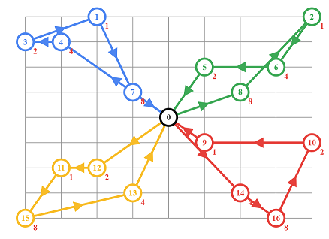

In [1]:
import networkx as nx

k = 4       # number of vehicles
n = 20      # number of demand points

depot = 0                       
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1)  

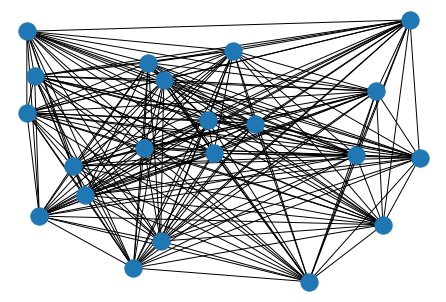

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random
my_pos = { i : ( random.random(), random.random() ) for i in dem_points } # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : 20 for i in dem_points }
q[depot] = 0

In [5]:
import gurobipy as gp
from gurobipy import GRB

In [6]:
# First, solve a relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[e]['length'] * x[e] for e in G.edges ), GRB.MINIMIZE )

# Degree-2 constraints
m.addConstrs( gp.quicksum( x[e] for e in G.edges if e in G.edges(i) ) == 2 for i in dem_points )

# Degree-(2*k) constraints at depot
m.addConstr( gp.quicksum( x[e] for e in G.edges if e in G.edges(depot) ) == 2*k )

m.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [7]:
# create a function to separate the rounded capacity inequalities (or subtour elimination)
def rounded_capacity_ineq(m, where):
    
    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP solution
        xval = m.cbGetSolution(m._x)
        
        # which edges are selected?
        tour_edges = [ e for e in m._G.edges if xval[e] > 0.5 ]
        
        # if connected, add rounded capacity inequalities (if any are violated)
        if nx.is_connected( m._G.edge_subgraph( tour_edges ) ):
            
            nondepot_edges = [ (i,j) for (i,j) in tour_edges if m._depot not in {i,j} ]
            
            for component in nx.connected_components( m._G.edge_subgraph( nondepot_edges ) ):
                
                component_demand = sum( m._q[i] for i in component )
                
                if component_demand > Q:
                    
                    cut_edges = [ (i,j) for (i,j) in m._G.edges if ( i in component) ^ ( j in component ) ]
                    m.cbLazy( gp.quicksum( m._x[e] for e in cut_edges ) >= 2 * math.ceil( component_demand / m._Q ) )
        
        # else, add subtour elimination constraints for non-depot components
        else: 
            
            for component in nx.connected_components( m._G.edge_subgraph( tour_edges ) ):
                
                if m._depot not in component:
                    
                    inner_edges = [ (i,j) for (i,j) in m._G.edges if i in component and j in component ]
                    m.cbLazy( gp.quicksum( m._x[e] for e in inner_edges ) <= len(component) - 1 )

In [8]:
# tell Gurobi that we will be adding (lazy) constraints
m.Params.lazyConstraints = 1

# designate the callback routine 
m._callback = rounded_capacity_ineq

# add the variables and graph to our model object, for use in the callback
m._x = x
m._G = G
m._q = q
m._Q = Q
m._depot = depot

# solve the MIP with our callback
m.optimize(m._callback)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 21 rows, 210 columns and 420 nonzeros
Model fingerprint: 0xb8a9c3f2
Variable types: 0 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 8e+00]
Presolve time: 0.00s
Presolved: 21 rows, 210 columns, 420 nonzeros
Variable types: 0 continuous, 210 integer (210 binary)

Root relaxation: objective 5.722794e+00, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.72279    0    6          -    5.72279      -     -    0s
     0     0    5.81214    0    9          -    5.81214      -     -    0s
     0     

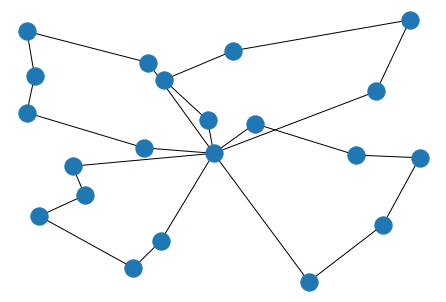

In [9]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)